# MARIO matching and integration pipeline

This tutorial will guide you through a list of general steps to perform matching and integration of single cell proteomic datasets. For R usesers please refer to the R tutorial for MARIO.

This script will include matching and integration of two or more then two datasets. First we will start with analysis on bone marrow cells [cite-seq](https://satijalab.org/seurat/articles/multimodal_reference_mapping.html#example-2-mapping-human-bone-marrow-cells-1) and [cytof](https://github.com/lmweber/benchmark-data-Levine-32-dim) cells. The data is same as we presented in the [paper](https://www.google.com/webhp?hl=en&ictx=2&sa=X&ved=0ahUKEwjdv9mYldfyAhUrJTQIHS4jBcQQPQgJ). First we load up MARIO in python:


In [1]:
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator

from mario.match import Mario # main object
from mario.match_utils import eval_matching_accuracy # for evaluating matching accuracy
from mario.match import pipelined_mario # for running the overall pipeline

## 1. Read in data and structure

We read in the two datasets, both protein features, with row as cells and column with features: overlapping or non-overlapping protein types (remember to make sure overlapping proteins have the same name accross datasets). Here the two datasets we used also contains a column of cell IDs and a column of cell types. These are **optional** and will not affect the **MARIO** mathcing and integration.

**Note**: *If there exists inner sturcture of rows and cell types in the dataset (eg. an imaging data where row 1 - row 5000 are all B cells due to same FOV of germinal center) the best practice is to randomnize the rows before matching, as extremely unbalanced cell population when running in certain parameters (high ```batches```) can sometimes give sub-optimal results.*

In [2]:
# panda only?
df1 = pd.read_csv("/home/bkzhu/SNE-multi/figure_rcode/figure_related_code_submit/github_tutorial_relate/bmcite_forSIM.csv")
df2 = pd.read_csv("/home/bkzhu/SNE-multi/figure_rcode/figure_related_code_submit/github_tutorial_relate/levine32_forSIM.csv")
# cell type annotations, used for downstream analysis etc
df1_labels = df1['cluster.info'].to_numpy()
df2_labels = df2['cluster.info'].to_numpy()
# remove non-numerical columns
df1 = df1.drop(['Unnamed: 0', 'cluster.info'], 1)
df2 = df2.drop(['Unnamed: 0', 'cluster.info'], 1)
df1.head()

,CD11a,CD11c,CD123,CD127.IL7Ra,CD14,CD16,CD161,CD19,CD197.CCR7,CD25,...,CD38,CD4,CD45RA,CD45RO,CD56,CD57,CD69,CD79b,CD8,HLA.DR
0,1.438352,0.912286,0.342896,0.460154,0.363419,0.900484,0.363419,0.256314,0.422575,0.210040,...,1.973215,0.888540,1.213869,0.210040,0.278673,0.760534,0.732842,0.136347,0.826584,2.028515
1,2.140502,0.485698,0.060654,1.305309,0.223242,0.446465,0.223242,0.171928,0.223242,0.000000,...,1.178997,3.633121,2.290450,0.060654,0.117838,0.754033,0.405630,0.000000,0.865283,0.559828
2,2.820346,0.706906,0.115421,1.338668,0.218888,0.477309,0.381797,0.218888,0.257453,0.136989,...,1.015877,3.457368,0.618652,1.100769,0.024175,0.430693,0.446474,0.047779,0.550475,0.903470
3,3.818838,2.830333,0.500528,0.281259,2.186431,0.396891,0.239539,0.281259,0.225237,0.102796,...,2.140819,1.207691,0.671078,0.623863,0.052718,0.553778,1.407460,0.118947,0.671078,1.863981
4,1.843356,1.190756,0.535925,0.335635,0.356535,0.569913,0.224034,2.372073,0.610836,0.200138,...,1.056390,0.387087,2.897020,0.137772,0.124818,0.335635,0.870671,0.634609,0.665452,3.048056


## 2. Parameter Screening and step-by-step MARIO

**MARIO** involves using a series of hyper-parameters. You can use the default numbers we suggested in the package for those hyperparameters, although to achieve optimal performance, we suggest tailoring these hyper-parameters for each dataset and do a step-by-step MARIO analysis. Here we will screen these parameters in a subsampled version of our dataset. You can also run this part with the full dataset but it could take some time depending on the data size.

In [3]:
# subsample the dataset for testing
np.random.seed(42)
id1 = np.random.choice(df1.shape[0], 2000, replace=False)
id2 = np.random.choice(df2.shape[0], 4000, replace=False)

df1_sub = df1.iloc[id1, :]
df2_sub = df2.iloc[id2, :]
# annotation of cells, optional, we use this for downstream analysis
df1_sub_labels = df1_labels[id1]
df2_sub_labels = df2_labels[id2]

### Parameters for overlapping feature matching:

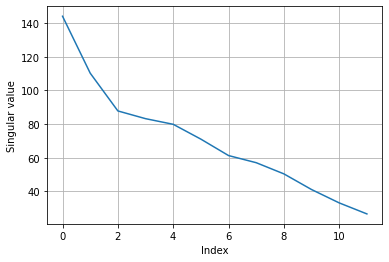

In [4]:
# construct the MARIO object
mario = Mario(df1_sub, df2_sub, normalization=True)
# compute distance matrix using overlapping features
_, singular_values = mario.compute_dist_ovlp(n_components=12)
# visualize singular values to select n_components
fig, ax = plt.subplots()
ax.plot(list(range(len(singular_values))), singular_values)
ax.set(xlabel='Index', ylabel='Singular value')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.grid()

We use this plot to decide how many components to use during mathcing with overlapping features, similar to the concept used with Elbow plots during PCA reduction. From this plot any value **above 6** looks good, we choose 10 here.

In [5]:
# any value above six looks good; let us choose 10
_ = mario.compute_dist_ovlp(n_components=10)
# specify how many cells in df2 should be matched to one cell in df1, we use the standard 1v1 matching
mario.specify_matching_params(1)

**Optional**: We also provide the option to run the **MARIO** matching with sparsity. Running with sparsity could reduce the run time if the data size is large, and potentially be a denoising step. We provide a function find the best sparsity number to use:

In [6]:
# [optional] check the minimum valid sparsity level
mario.search_minimum_sparsity(mario.dist['ovlp'], slackness=1, init_sparsity=100, verbose=True)

If sparsity>=4000, then there is a valid matching; if sparsity<1, then there is no valid matching.
If sparsity>=4000, then there is a valid matching; if sparsity<101, then there is no valid matching.
If sparsity>=2050, then there is a valid matching; if sparsity<101, then there is no valid matching.
If sparsity>=1075, then there is a valid matching; if sparsity<101, then there is no valid matching.
If sparsity>=588, then there is a valid matching; if sparsity<101, then there is no valid matching.
If sparsity>=344, then there is a valid matching; if sparsity<101, then there is no valid matching.
If sparsity>=222, then there is a valid matching; if sparsity<101, then there is no valid matching.
If sparsity>=161, then there is a valid matching; if sparsity<101, then there is no valid matching.
If sparsity>=131, then there is a valid matching; if sparsity<101, then there is no valid matching.
If sparsity>=116, then there is a valid matching; if sparsity<101, then there is no valid matching

(103, 104)

Based on the result, any sparsity level > 104 will give valid matching, thus we will use 120 and perform matching with overlapping features:

*Note: the sparsity value is related (in ratio) to the amount of cells in n1.*

In [7]:
# any a sparsity level >= 104 will give a valid matching 
# let us choose 120
_ = mario.match_cells('ovlp', sparsity=160, mode='auto')

**Optional**: If you have the basic annotations of the cell types of the two datasets (the names are the same), we also provides a function that you can do a quick sanity check of how well the matching was:

In [8]:
# evaluate accuracy
eval_matching_accuracy(df1_sub_labels, df2_sub_labels, mario.matching['ovlp'], 'maj')

0.9335

### Parameters for refined all feature matching:

Then we will start testing how many components to use in the refined matching (which will use all features including non-overlapping features):

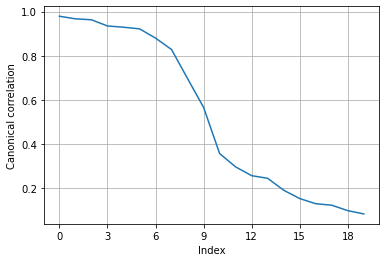

In [9]:
# compute distance matrix using all the features
_, canonical_correlations = mario.compute_dist_all('ovlp', n_components=20)
# visualize canonical correlations to select n_components
fig, ax = plt.subplots()
ax.plot(list(range(len(canonical_correlations))), canonical_correlations)
ax.set(xlabel='Index', ylabel='Canonical correlation')
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.grid()

Based on the plot we can see a steep drop of canonical correlation at 9 components, therefore, we should choose **> 9** components for refined matching, here we choose 12:

In [10]:
_, canonical_correlations = mario.compute_dist_all('ovlp', n_components=12)
# perform the refined matching
_ = mario.match_cells('all', sparsity=None, mode='auto')

**Optional**: Similarly if we have the basic annotations we can test the performance of matching. Note although the increase of accuracy is not significant, the annotation is only very basic and broad, and the matching accuracy will see a larger raise if there is more underlying information hiding in the non-overlapping features/ or the annotations is more specific.

In [11]:
eval_matching_accuracy(df1_sub_labels, df2_sub_labels, mario.matching['all'], 'maj')

0.941

### [Optional] MARIO Matchability test

However, in most cases we don't have an annotation file to quickly validate if the matching of MARIO is solid. Moreover, many datasets should not be forcefully match and integrated (due to underlying biology or poor quality data). Therefore, we provide a rigorous statistical testing to confirm the two dataset can be matched. Note this step could be slow depending on the datasize and parameter selected: 

In [12]:
mario.matchable(n_sim=20, top_k=5, flip_prob=0.2, subsample_prop=1, verbose=True)

Random sign flip, round 0...
Random sign flip, round 1...
Random sign flip, round 2...
Random sign flip, round 3...
Random sign flip, round 4...
Random sign flip, round 5...
Random sign flip, round 6...
Random sign flip, round 7...
Random sign flip, round 8...
Random sign flip, round 9...
Random sign flip, round 10...
Random sign flip, round 11...
Random sign flip, round 12...
Random sign flip, round 13...
Random sign flip, round 14...
Random sign flip, round 15...
Random sign flip, round 16...
Random sign flip, round 17...
Random sign flip, round 18...
Random sign flip, round 19...


(0.0, 0.0)

The test will give you two p values (#1 for ovlp matching, #2 for all matching). We suggest **not to perform** a matching/integration analysis of any kind on datasets with an anverage $p > 0.05$.

### Find the best interpolation of overlapping and all matching

Then we can find the best balance between the ```ovlp``` feature matching and ```all``` feature mathcing by the interpolate function. The best weight will be finded and the corresponding match will be stored inside the object:

In [13]:
best_wt, _ = mario.interpolate(n_wts=5, top_k=5, verbose=True)

Now at iteration 0, wt=0.0
Now at iteration 1, wt=0.25
Now at iteration 2, wt=0.5
Now at iteration 3, wt=0.75
Now at iteration 4, wt=1.0


### Joint regularized filtering of sub-optimal matching

At the very last step, we will filter out the potential sub-optimal matching pairs via joint regularized filtering. The filtering will be formed on the matching based on weighted interpolation. The parameter ```n_clusters``` should be approximately be the number of cell populations, and ```n_components``` will be the number of components used during filtering, suggest using number in between the components used during ```ovlp``` and ```all``` matching. The parameter ```bad_prop``` controls the filtering strength and will be more stringent if increased, we suggest using $0.1$ - $0.3$. After filtering, matched cell pairs will be less rows of original data ```df1_sub```.

In [14]:
_  = mario.filter_bad_matches(
    'wted', n_clusters=10, n_components=10, bad_prop=0.2,
    max_iter=30, tol=1e-5, verbose=True
)

Now at iteration 0, current loss is 5.711970392186894.
Now at iteration 1, current loss is 5.585817055079544.
Now at iteration 2, current loss is 5.573483639053824.
Now at iteration 3, current loss is 5.567733255479445.
Now at iteration 4, current loss is 5.567264976783244.
Now at iteration 5, current loss is 5.567178228185772.
Now at iteration 6, current loss is 5.567178228185772.


### Matching result access

All the matching produced by MARIO are stored in object ```mario.matching``` and different matching results can be accessed via keys eg. ```ovlp```, ```all```,```wted```, ```final```. The matching result contains a list of numbers which corresponding of the matching rows (eg. ```mario.matching['final'][0]``` is 41, meaning 0th row of ```df1_sub``` is matched to 41th row of ```df2_sub```. Empty means match pair beeing removed after filtering. Here we reformat the matching result to a pd dataframe for checking:

In [15]:
## reformat the MARIO matching results to a dataframe
df1_rowidx=list(range(len(mario.matching['final']))) # extract the final matching
filtered_out=[i for i,x in enumerate(mario.matching['final']) if not x]
match_final_df1 =[e for e in df1_rowidx if not e in filtered_out]
match_final_df2 = [item for sublist in mario.matching['final'] for item in sublist]
matching_final_df = pd.DataFrame(np.column_stack([match_final_df1, match_final_df2]))
matching_final_df

,0,1
0,0,41
1,1,631
2,2,395
3,3,495
4,4,3801
...,...,...
1946,1995,863
1947,1996,1286
1948,1997,3973
1949,1998,289


**optional**: We also provides the option to do the standard k-NN matching of the MARIO matched pairs:

In [16]:
_ = mario.knn_matching('wted', k=5)

### Joint embedding

With the cells having high quality pairs, we can use CCA to produce the sub-space scores, that can be used for downstream analysis eg. visualization with t-sne/umap, joint clustering and more.

In [17]:
_, cca = mario.fit_cca(mario.matching['final'], n_components=10, max_iter=10000)
df1_sub_cca, df2_sub_cca = cca.x_scores_, cca.y_scores_

Optionally, if we have the labels, we can also quickly check how the matching was performing after filtering, and we will see a furthur increase in matching accuracy:

In [18]:
eval_matching_accuracy(df1_sub_labels, df2_sub_labels, mario.matching['final'], 'maj')

0.9502819067145054

## 3. Pipeline version MARIO with one line


Previously we have showcased a step-by-step style **MARIO** and parameter screening. For easy impelmentation, we also provide a compact function ```pipelined_mario``` to perform all the steps in **MARIO** in one line. Please note the time and memory usage is directly linked to cell numbers in datasets and should not run locally if matching a total of more than 100k cells. In our tutorial case we are matching the full size datasets and a total of **~30k** cells matching towards **~100k** cells, thus the code chunk could take ~40mins and ~25GB of space (peak). The time and memory usage can be reduced by increasing the ```n_batches``` parameter (inputing smaller cell numbers each iteration and process in stream-line).

Remember you can use the default parameters but **MARIO** will perform better with customized ones. Please refer to our [documentation](https://github.com/shuxiaoc/mario-py/blob/fef06cdfb74017456136741dfeaf61fe0b94b608/src/mario/match.py) inside the package for detailed information.

*Note: although the minimal sparsity level we searched previously was around 100, here the n1 of each batch is around 6k cells, so we roughly made sparsity to 300-400.*

In [19]:
final_matching_lst, embedding_lst = pipelined_mario(
    data_lst=[df1, df2], normalization=True, n_batches=5,
    n_matched_per_cell=1, sparsity_ovlp=400, sparsity_all=400,
    n_components_ovlp=10, n_components_all=12,
    n_cancor=5, n_wts=4,
    n_clusters=10, n_components_filter=10, bad_prop=0.2, max_iter_filter=20,
    knn=False, embed_dim=10, max_iter_embed=500, save_path='../data', verbose=False
)

Matching data_lst[0] with data_lst[1]
Now at batch 0
Matching using overlapping features...
Matching using all features...
Finding the best interpolated matching...
Filtering bad matched pairs...
Now at batch 1
Matching using overlapping features...
Filtering bad matched pairs...
Now at batch 2
Matching using overlapping features...
Matching using all features...
Finding the best interpolated matching...
Filtering bad matched pairs...
Now at batch 3
Matching using overlapping features...
Matching using all features...
Finding the best interpolated matching...
Filtering bad matched pairs...
Now at batch 4
Matching using overlapping features...
Matching using all features...
Finding the best interpolated matching...
Filtering bad matched pairs...
Stitching batch-wise matchings together...
Matching is done, calculating joint embeddings...
Saving the results...
Done!


## 4. Downstream Analysis

After the MARIO matching and integration pipeline, we can perform various downstream analysis. Here we will just do some simple showcase of t-sne visualization. These results are also saved out and are compatible for furthur analysis with popular packages eg ```scanpy```

First we can make the t-sne plots:

In [20]:
import seaborn as sns
from sklearn.manifold import TSNE
# do t-sne plotting
tsne = TSNE(n_components=2, verbose=0, perplexity=30, n_iter=1000)
# only use 10 components
tsne_results = tsne.fit_transform(np.vstack([embedding_lst[0][:,0:10], embedding_lst[1][:,0:10]]))
embedding_gcca = pd.DataFrame(tsne_results, columns = ['tsne1', 'tsne2'])


<AxesSubplot:xlabel='tsne1', ylabel='tsne2'>

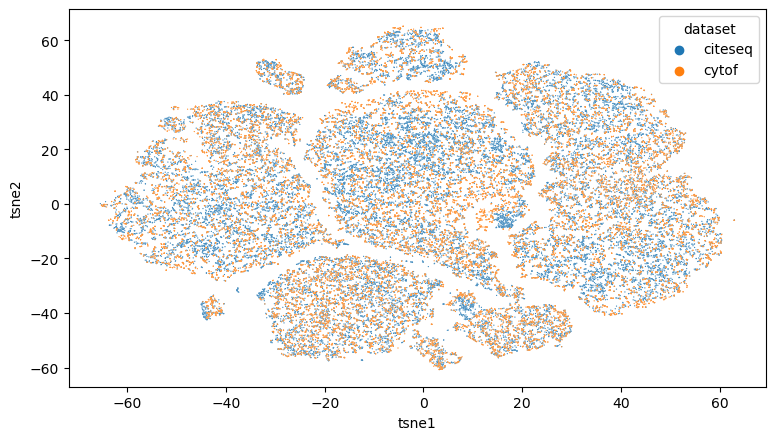

In [21]:
# input labels dataset of origin
embedding_gcca['dataset'] = np.repeat(["citeseq","cytof"], [embedding_lst[0].shape[0], embedding_lst[0].shape[0]], axis=0)
fig=plt.figure(figsize=(9,5), dpi= 100, facecolor='w', edgecolor='k')
sns.scatterplot(data=embedding_gcca, x='tsne1', y='tsne2', hue='dataset', s=0.8)


<AxesSubplot:xlabel='tsne1', ylabel='tsne2'>

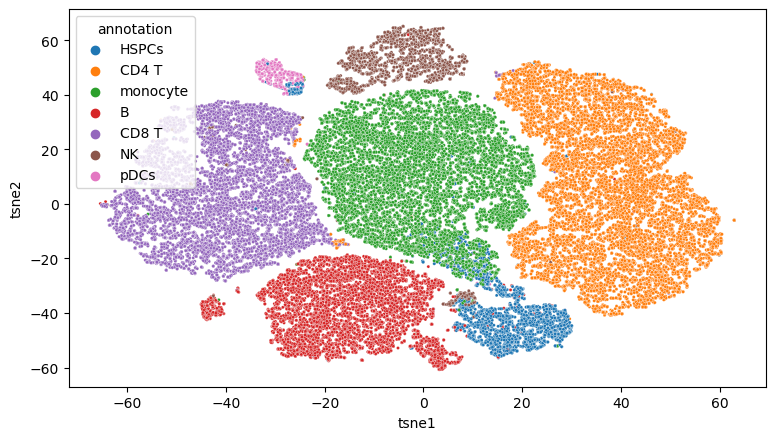

In [22]:
# we can also color by cell types

## reformat the MARIO matching results
df1_rowidx=list(range(len(final_matching_lst[1])))
filtered_out=[i for i,x in enumerate(final_matching_lst[1]) if not x]

match_final_df1 =[e for e in df1_rowidx if not e in filtered_out]
match_final_df2 = [item for sublist in final_matching_lst[1] for item in sublist]

# find the original labels
embedding_gcca['annotation'] = np.hstack([df1_labels[match_final_df1], df2_labels[match_final_df2]])
fig=plt.figure(figsize=(9,5), dpi= 100, facecolor='w', edgecolor='k')
sns.scatterplot(data=embedding_gcca, x='tsne1', y='tsne2', hue='annotation', s=5)

Other downstream analysis related to the matching result can be performed either.